In [2]:
import torch.nn.init as init
from torch.autograd import Variable
import torch.nn as nn
import matplotlib.pyplot as plt
import torch
import numpy as np
import random

In [3]:
# set seed function
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
SEED = 42

In [4]:
# data distribution
set_seed(SEED)

def get_data(n, p_maj, r_sc, label_noise):
    y = np.random.choice([-1, 1], n, p=[0.5, 0.5])
    n_maj = int(n * p_maj)
    x_core = np.array([np.random.normal(y[i], 0.5) for i in range(n)]) * 0.5
    x_spu = y * np.random.choice([-1, 1], n, p=[1-p_maj, p_maj])
    g = np.array(x_spu * y < 0, dtype=int)
    y = (2 * np.random.binomial(1, 1.0 - label_noise, n) - 1) * y
    return np.stack([x_core, x_spu], axis=1), y, g
    
def plot_data(x, y):
    plt.scatter(x[y==1, 0], x[y==1, 1], c='blue', s=4., label='$y=+1$', alpha=0.95)
    plt.scatter(x[y==-1, 0], x[y==-1, 1], c='orange', s=4., label='$y=-1$', alpha=0.95)
    plt.xlabel("Core", size=14)
    plt.ylabel("Spurious", size=14)
    plt.legend()
    
def plot_dbdry(x, y, m, noise_dim=0):
    plot_data(x, y)
    min1, max1 = x[:, 0].min()-0.1, x[:, 0].max()+0.1
    min2, max2 = x[:, 1].min()-0.1, x[:, 1].max()+0.1
    x1grid = np.arange(min1, max1, 0.02)
    x2grid = np.arange(min2, max2, 0.02)
    xx, yy = np.meshgrid(x1grid, x2grid)
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    grid = np.hstack((r1,r2))
    if noise_dim > 0:
        grid = np.concatenate([grid, np.zeros((len(grid), noise_dim))], axis=1)
    with torch.no_grad():
        y_hat = m.get_prob(torch.FloatTensor(grid).cuda()).cpu().numpy()
    zz = y_hat.reshape(xx.shape)
    cbar = plt.contourf(xx, yy, zz, cmap='RdBu', alpha=0.25)
    plt.colorbar(cbar)
    
def plot_loss(x, l):
    cbar = plt.scatter(x[:, 0], x[:, 1], c=l, cmap='Greys')
    plt.xlabel("Core", size=14)
    plt.ylabel("Spurious", size=14)
    plt.colorbar(cbar)

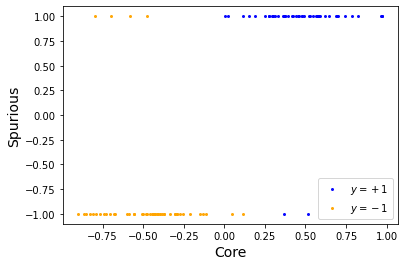

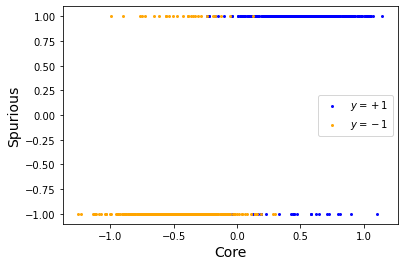

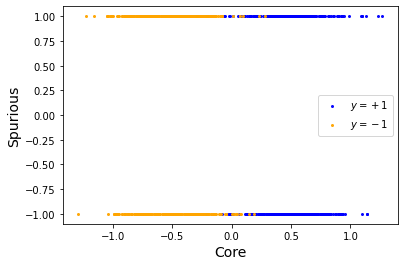

In [5]:
set_seed(SEED)
p_maj = 0.95
r_sc = 200
label_noise = 0.0
noise_dim = 10
dim = noise_dim + 2

x_tr, y_tr, g_tr = get_data(100, p_maj=p_maj, r_sc=r_sc, label_noise=label_noise)
x_tr = torch.FloatTensor(x_tr)
if noise_dim:
    x_tr = torch.cat([x_tr, torch.randn(len(x_tr), noise_dim)], dim=1)
y_tr = torch.LongTensor(y_tr)

x_te_id, y_te_id, g_te_id = get_data(1000, p_maj=p_maj, r_sc=r_sc, label_noise=0.)
x_te_id = torch.FloatTensor(x_te_id)
if noise_dim:
    x_te_id = torch.cat([x_te_id, torch.randn(len(x_te_id), noise_dim)], dim=1)
y_te_id = torch.LongTensor(y_te_id)

x_te_ood, y_te_ood, g_te_ood = get_data(1000, p_maj=0.5, r_sc=r_sc, label_noise=0.)
x_te_ood = torch.FloatTensor(x_te_ood)
if noise_dim:
    x_te_ood = torch.cat([x_te_ood, torch.randn(len(x_te_ood), noise_dim)], dim=1)
y_te_ood = torch.LongTensor(y_te_ood)

plot_data(x_tr, y_tr)
plt.show()
plot_data(x_te_id, y_te_id)
plt.show()
plot_data(x_te_ood, y_te_ood)

In [6]:
# model
class Model(torch.nn.Module):
    
    def __init__(self, dim, C):
        super(Model, self).__init__()
        self.classifier = torch.nn.Linear(dim, C)
        self.init()
        
    def init(self):
        for m in self.modules():
            if isinstance(m, torch.nn.Linear):
                torch.nn.init.kaiming_normal_(m.weight)
                torch.nn.init.zeros_(m.bias)
                
    def forward(self, x):
        logits = self.classifier(x)
        return logits
    
    def get_prob(self, x):
        return torch.nn.functional.softmax(self(x), dim=1)[:, 1]
        

class Adv(torch.nn.Module):
    
    def __init__(self, dim, nlabels=2, t=1):
        super(Adv, self).__init__()
        self.classifier = nn.ModuleList([torch.nn.Linear(dim, 1, bias=False) for _ in range(nlabels)])
        self.nlabels = nlabels
        self.t = t
        self.init()
        
    def init(self):
        for m in self.modules():
            if isinstance(m, torch.nn.Linear):
                torch.nn.init.kaiming_normal_(m.weight)
                if m.bias:
                    torch.nn.init.zeros_(m.bias)

    def forward(self, X, y):
        output = torch.zeros_like(y).float() 
        for label in range(self.nlabels):
            output[y==label] = self.classifier[label](X[y==label]).squeeze()
        return torch.sigmoid(output)
    
    def get_scaled_logits(self, X, y):
        output = torch.zeros_like(y).float() 
        for label in range(self.nlabels):
            output[y==label] = self.classifier[label](X[y==label]).squeeze()
        return self.t * output
    
    
class Dummy(nn.Module):
    def __init__(self, w, t=1):
        super(Dummy, self).__init__()
        self.w = w
        self.t = t
    def forward(self, x):
        return self.w(x)
    def get_prob(self, x):
        return torch.sigmoid(self.t * self(x))
        


In [7]:
set_seed(SEED)

m = Model(dim=dim, C=2).cuda()
# w_tr = torch.FloatTensor(g_tr * len(g_tr)/sum(g_tr) + (1-g_tr) * len(g_tr)/sum(1-g_tr)).cuda()
w_tr = (torch.ones(len(g_tr)) * (1/len(g_tr))).cuda()

lr = 1e-1
lossfn = torch.nn.CrossEntropyLoss(reduction='none')
opt = torch.optim.SGD(m.parameters(), lr=lr, weight_decay=0.)
n_epochs = 10000

def get_acc(x, y, m):
    xte = x.cuda()
    yte = ((y+1) / 2).long().cuda()
    with torch.no_grad():
        return ((torch.nn.functional.softmax(m(xte), dim=1)[:, 1] >=0.5).long() == yte).sum() / len(yte)

xt = x_tr.cuda()
yt = ((y_tr+1) / 2).long().cuda()

for ep in range(n_epochs):
    opt.zero_grad()
    logits = m(xt)
    loss = lossfn(logits, yt)
    (loss * w_tr).sum().backward()
    opt.step()
        
    if ep % 500 == 0:
        train_acc = get_acc(x_tr, y_tr, m)
        test_id_acc = get_acc(x_te_id, y_te_id, m)
        test_ood_acc = get_acc(x_te_ood, y_te_ood, m)
        print('ep: {:d} loss: {:.3f} train: {:.2f} test_id: {:.2f} test_ood: {:.2f}'.format(ep, loss.mean().item(), train_acc, test_id_acc, test_ood_acc))
        

ep: 0 loss: 1.251 train: 0.44 test_id: 0.42 test_ood: 0.50
ep: 500 loss: 0.044 train: 1.00 test_id: 0.96 test_ood: 0.61
ep: 1000 loss: 0.026 train: 1.00 test_id: 0.96 test_ood: 0.66
ep: 1500 loss: 0.019 train: 1.00 test_id: 0.96 test_ood: 0.67
ep: 2000 loss: 0.015 train: 1.00 test_id: 0.96 test_ood: 0.69
ep: 2500 loss: 0.012 train: 1.00 test_id: 0.97 test_ood: 0.69
ep: 3000 loss: 0.011 train: 1.00 test_id: 0.97 test_ood: 0.70
ep: 3500 loss: 0.009 train: 1.00 test_id: 0.97 test_ood: 0.71
ep: 4000 loss: 0.008 train: 1.00 test_id: 0.97 test_ood: 0.71
ep: 4500 loss: 0.007 train: 1.00 test_id: 0.97 test_ood: 0.71
ep: 5000 loss: 0.007 train: 1.00 test_id: 0.97 test_ood: 0.71
ep: 5500 loss: 0.006 train: 1.00 test_id: 0.97 test_ood: 0.71
ep: 6000 loss: 0.006 train: 1.00 test_id: 0.97 test_ood: 0.72
ep: 6500 loss: 0.005 train: 1.00 test_id: 0.97 test_ood: 0.72
ep: 7000 loss: 0.005 train: 1.00 test_id: 0.97 test_ood: 0.72
ep: 7500 loss: 0.005 train: 1.00 test_id: 0.97 test_ood: 0.72
ep: 8000 los

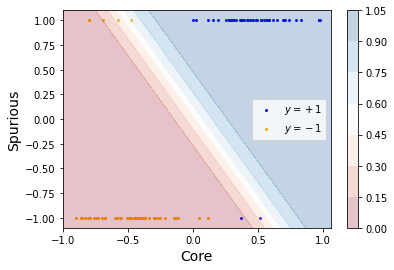

In [8]:
plot_dbdry(x_tr, y_tr, m, noise_dim=noise_dim)

In [9]:
set_seed(SEED)

m = Model(dim=dim, C=2).cuda()
w_tr = torch.FloatTensor(g_tr * len(g_tr)/sum(g_tr) + (1-g_tr) * len(g_tr)/sum(1-g_tr)).cuda()

lr = 1e-1
lossfn = torch.nn.CrossEntropyLoss(reduction='none')
opt = torch.optim.SGD(m.parameters(), lr=lr, weight_decay=0.2)
n_epochs = 10000

def get_acc(x, y, m):
    xte = x.cuda()
    yte = ((y+1) / 2).long().cuda()
    with torch.no_grad():
        return ((torch.nn.functional.softmax(m(xte), dim=1)[:, 1] >=0.5).long() == yte).sum() / len(yte)

xt = x_tr.cuda()
yt = ((y_tr+1) / 2).long().cuda()

for ep in range(n_epochs):
    opt.zero_grad()
    logits = m(xt)
    loss = lossfn(logits, yt)
    (loss * w_tr).sum().backward()
    opt.step()
        
    if ep % 500 == 0:
        train_acc = get_acc(x_tr, y_tr, m)
        test_id_acc = get_acc(x_te_id, y_te_id, m)
        test_ood_acc = get_acc(x_te_ood, y_te_ood, m)
        print('ep: {:d} loss: {:.3f} train: {:.2f} test_id: {:.2f} test_ood: {:.2f}'.format(ep, loss.mean().item(), train_acc, test_id_acc, test_ood_acc))
        

ep: 0 loss: 1.251 train: 0.74 test_id: 0.65 test_ood: 0.62
ep: 500 loss: 0.015 train: 1.00 test_id: 0.96 test_ood: 0.82
ep: 1000 loss: 0.015 train: 1.00 test_id: 0.96 test_ood: 0.82
ep: 1500 loss: 0.015 train: 1.00 test_id: 0.96 test_ood: 0.82
ep: 2000 loss: 0.015 train: 1.00 test_id: 0.96 test_ood: 0.82
ep: 2500 loss: 0.015 train: 1.00 test_id: 0.96 test_ood: 0.82
ep: 3000 loss: 0.015 train: 1.00 test_id: 0.96 test_ood: 0.82
ep: 3500 loss: 0.015 train: 1.00 test_id: 0.96 test_ood: 0.82
ep: 4000 loss: 0.015 train: 1.00 test_id: 0.96 test_ood: 0.82
ep: 4500 loss: 0.015 train: 1.00 test_id: 0.96 test_ood: 0.82
ep: 5000 loss: 0.015 train: 1.00 test_id: 0.96 test_ood: 0.82
ep: 5500 loss: 0.015 train: 1.00 test_id: 0.96 test_ood: 0.82
ep: 6000 loss: 0.015 train: 1.00 test_id: 0.96 test_ood: 0.82
ep: 6500 loss: 0.015 train: 1.00 test_id: 0.96 test_ood: 0.82
ep: 7000 loss: 0.015 train: 1.00 test_id: 0.96 test_ood: 0.82
ep: 7500 loss: 0.015 train: 1.00 test_id: 0.96 test_ood: 0.82
ep: 8000 los

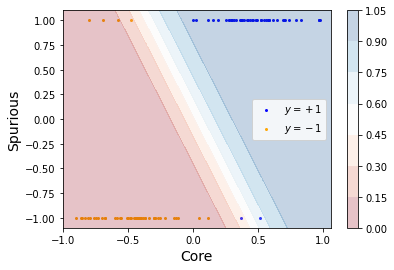

In [10]:
plot_dbdry(x_tr, y_tr, m, noise_dim=10)

In [11]:
set_seed(SEED)

m = Model(dim=dim, C=2).cuda()
lr = 1e-1
lossfn = torch.nn.CrossEntropyLoss(reduction='none')
opt = torch.optim.SGD(m.parameters(), lr=lr, weight_decay=0.001)
n_epochs = 20000

def get_acc(x, y, m):
    xte = x.cuda()
    yte = ((y+1) / 2).long().cuda()
    with torch.no_grad():
        return ((torch.nn.functional.softmax(m(xte), dim=1)[:, 1] >=0.5).long() == yte).sum() / len(yte)

xt = x_tr.cuda()
yt = ((y_tr+1) / 2).long().cuda()

# initialize weights to uniform
# q = np.array([sum(1-g_tr)/len(g_tr), sum(g_tr)/len(g_tr)])
q = np.array([0.5, 0.5])
eta = 0.01
B = 128

for ep in range(n_epochs):
    opt.zero_grad()
    # sample group
    # g = np.random.choice([0, 1], p=q) if np.random.uniform() < 0.99 else np.random.choice([0, 1])
    # sample batch from group
    g = np.random.choice([0, 1])
    idx = np.random.choice(np.where(g_tr==g)[0], B)
    bxt, byt = xt[idx], yt[idx]
    # compute loss
    logits = m(bxt)
    loss = lossfn(logits, byt).mean()
    # update weights
    q_hat = q
    q_hat[g] = q_hat[g] * np.exp(eta * loss.item())
    q_hat /= q_hat.sum()
    (loss * q_hat[g]).backward()  
    q = q_hat
    opt.step()
    if ep % 500 == 0:
        train_acc = get_acc(x_tr, y_tr, m)
        test_id_acc = get_acc(x_te_id, y_te_id, m)
        test_ood_acc = get_acc(x_te_ood, y_te_ood, m)
        print('ep: {:d} loss: {:.3f} train: {:.2f} test_id: {:.2f} test_ood: {:.2f}'.format(ep, loss.mean().item(), train_acc, test_id_acc, test_ood_acc))
        print(f'q: {q}', [lossfn(m(xt[g_tr==0]), yt[g_tr==0]).mean().item(), lossfn(m(xt[g_tr==1]), yt[g_tr==1]).mean().item()])



ep: 0 loss: 1.219 train: 0.44 test_id: 0.40 test_ood: 0.50
q: [0.50304629 0.49695371] [1.2389745712280273, 0.6823114156723022]
ep: 500 loss: 0.093 train: 0.98 test_id: 0.95 test_ood: 0.73
q: [0.57707428 0.42292572] [0.10260557383298874, 0.08686800301074982]
ep: 1000 loss: 0.059 train: 1.00 test_id: 0.95 test_ood: 0.75
q: [0.58120122 0.41879878] [0.06106777861714363, 0.05733051896095276]
ep: 1500 loss: 0.044 train: 1.00 test_id: 0.95 test_ood: 0.76
q: [0.5823039 0.4176961] [0.04589413106441498, 0.044148027896881104]
ep: 2000 loss: 0.032 train: 1.00 test_id: 0.96 test_ood: 0.77
q: [0.58367324 0.41632676] [0.03437851741909981, 0.042981695383787155]
ep: 2500 loss: 0.030 train: 1.00 test_id: 0.96 test_ood: 0.78
q: [0.58248036 0.41751964] [0.03341769054532051, 0.032879553735256195]
ep: 3000 loss: 0.028 train: 1.00 test_id: 0.96 test_ood: 0.78
q: [0.58245434 0.41754566] [0.03040800429880619, 0.030172666534781456]
ep: 3500 loss: 0.024 train: 1.00 test_id: 0.96 test_ood: 0.78
q: [0.58291275 0.4

ep: 0 ml: 1.215 al: 18.251 train: 0.46 test_id: 0.41 test_ood: 0.50 gamma: 3.662769


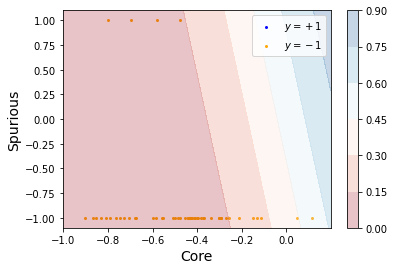

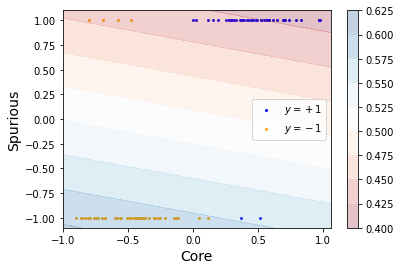

ep: 2000 ml: 0.005 al: 3.402 train: 1.00 test_id: 0.97 test_ood: 0.77 gamma: 0.027962


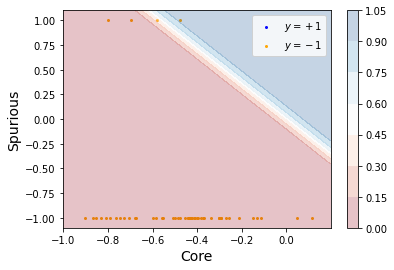

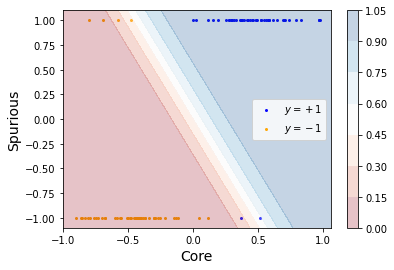

ep: 4000 ml: 0.004 al: 4.119 train: 1.00 test_id: 0.97 test_ood: 0.77 gamma: 0.018415


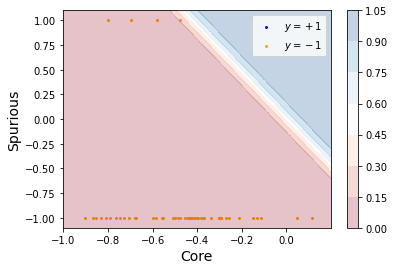

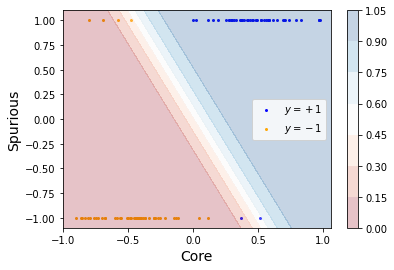

ep: 6000 ml: 0.004 al: 4.080 train: 1.00 test_id: 0.97 test_ood: 0.77 gamma: 0.018226


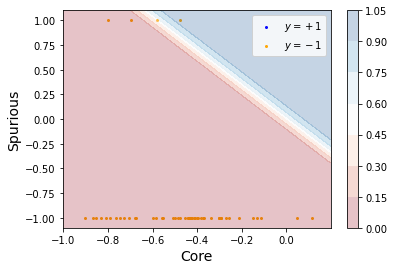

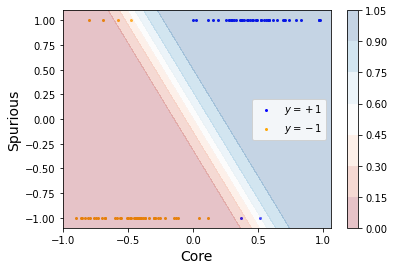

ep: 8000 ml: 0.003 al: 3.556 train: 1.00 test_id: 0.97 test_ood: 0.77 gamma: 0.017001


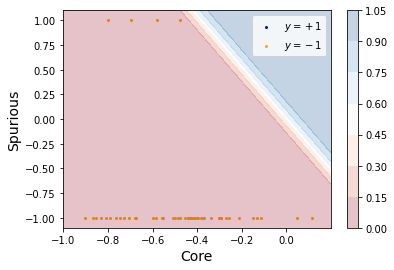

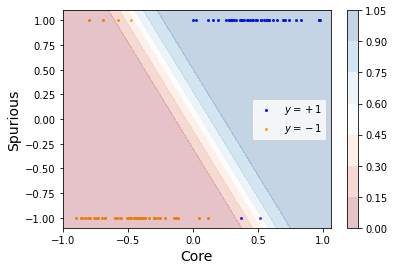

KeyboardInterrupt: 

In [143]:
set_seed(SEED)

m = Model(dim=dim, C=2).cuda()
a = Adv(dim=dim, t=10).cuda()
lr_m = 0.1
lr_a = 0.1
loss_m = torch.nn.CrossEntropyLoss(reduction='none')
loss_a = torch.nn.MSELoss(reduction='none')
opt_m = torch.optim.SGD(m.parameters(), lr=lr_m, weight_decay=0.001)
opt_a = torch.optim.SGD(a.parameters(), lr = lr_a)
n_epochs = 20000

def get_acc(x, y, m):
    xte = x.cuda()
    yte = ((y+1) / 2).long().cuda()
    with torch.no_grad():
            return ((torch.nn.functional.softmax(m(xte), dim=1)[:, 1] >=0.5).long() == yte).sum() / len(yte)

xt = x_tr.cuda()
yt = ((y_tr+1) / 2).long().cuda()

# initialize weights to uniform
gamma = 0.002
B = 64

for ep in range(n_epochs):
    # sample batch
    idx = np.random.choice(len(yt), B)
    bxt, byt = xt[idx], yt[idx]
    # compute loss
    ml = loss_m(m(bxt), byt)
    # compute wts
    wts = torch.sigmoid(a.get_scaled_logits(bxt, byt).squeeze())
    # update learner
    opt_m.zero_grad()
    (((ml * wts).sum() / wts.sum())).backward()  
    opt_m.step()
    # update weights
    
    for _ in range(1):
        al = 0.
        with torch.no_grad():
            ml = loss_m(m(bxt), byt)
        gamma = torch.quantile(ml, 0.95).item()
            
        def closure():
            global al
            al = 0.
            wts = a(bxt, byt).squeeze()
            for y in range(2):
                y_adv = (ml[byt==y] > gamma).float()
                # y_adv = ml[byt==y]
                al += loss_a(wts[byt==y], y_adv).mean() + 0.1 * torch.norm(a.classifier[y].weight, p=1)
            opt_a.zero_grad()
            al.backward()  
            return al
        opt_a.step(closure) 
    
    if ep % 2000 == 0:
        train_acc = get_acc(x_tr, y_tr, m)
        test_id_acc = get_acc(x_te_id, y_te_id, m)
        test_ood_acc = get_acc(x_te_ood, y_te_ood, m)
        print('ep: {:d} ml: {:.3f} al: {:.3f} train: {:.2f} test_id: {:.2f} test_ood: {:.2f} gamma: {:2f}'.format(ep, ml.mean().item(), al.mean().item(), train_acc, test_id_acc, test_ood_acc, gamma))
        plot_dbdry(x_tr[y_tr==-1, :], y_tr[y_tr==-1], Dummy(a.classifier[0], a.t), noise_dim=10)
        plt.show()
        plot_dbdry(x_tr, y_tr, m, noise_dim=10)
        plt.show()

ep: 0 ml: 1.002 al: -64.663 train: 0.50 test_id: 0.48 test_ood: 0.53 gamma: 3.111049


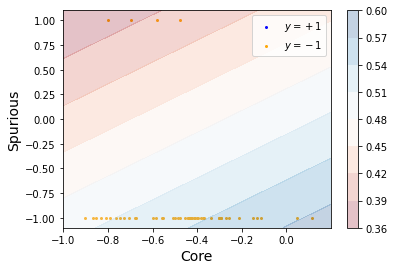

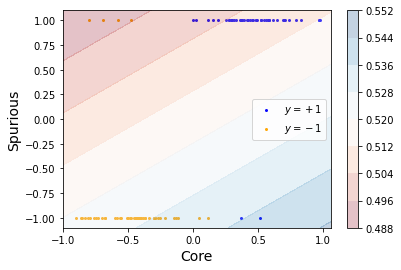

ep: 2000 ml: 0.026 al: -1.391 train: 1.00 test_id: 0.96 test_ood: 0.77 gamma: 0.139294


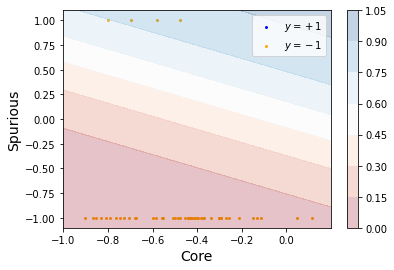

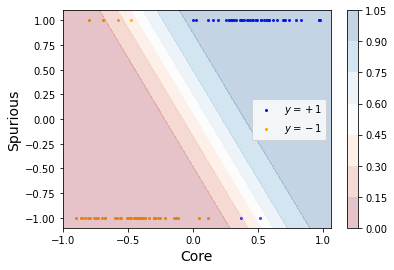

ep: 4000 ml: 0.014 al: -1.159 train: 1.00 test_id: 0.96 test_ood: 0.78 gamma: 0.074560


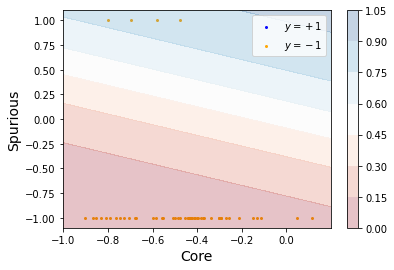

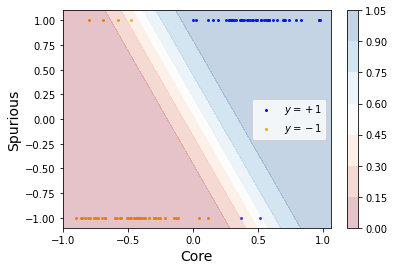

ep: 6000 ml: 0.015 al: -1.073 train: 1.00 test_id: 0.96 test_ood: 0.79 gamma: 0.073721


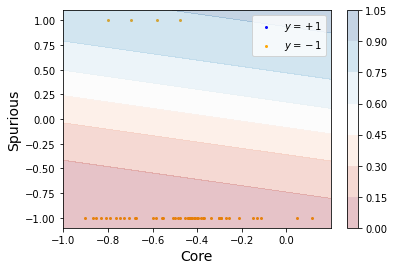

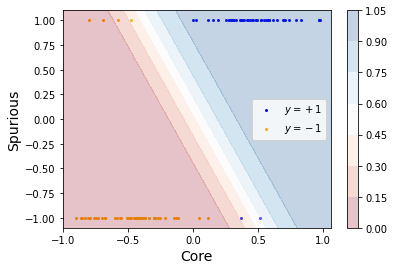

ep: 8000 ml: 0.010 al: -0.903 train: 1.00 test_id: 0.96 test_ood: 0.80 gamma: 0.062145


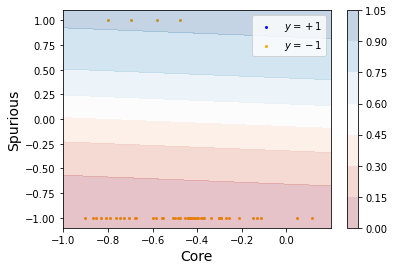

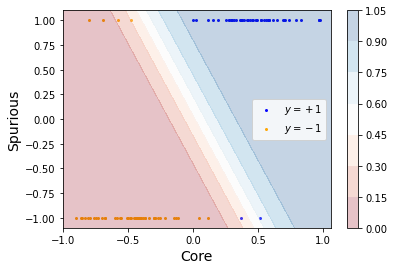

ep: 10000 ml: 0.019 al: -1.346 train: 1.00 test_id: 0.96 test_ood: 0.81 gamma: 0.109904


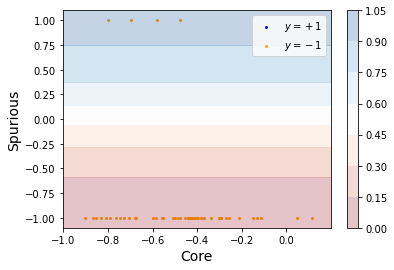

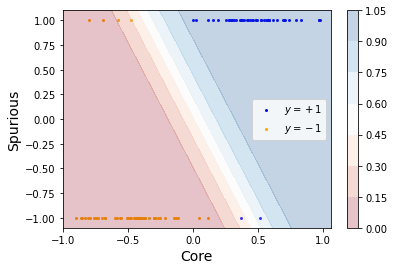

ep: 12000 ml: 0.023 al: -1.176 train: 1.00 test_id: 0.96 test_ood: 0.82 gamma: 0.114684


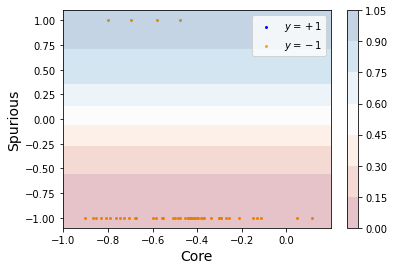

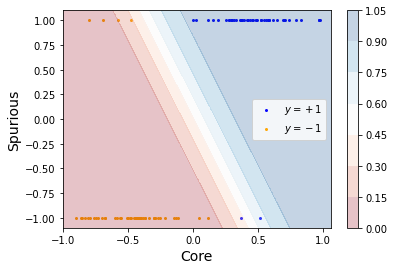

ep: 14000 ml: 0.024 al: -1.203 train: 1.00 test_id: 0.96 test_ood: 0.82 gamma: 0.098611


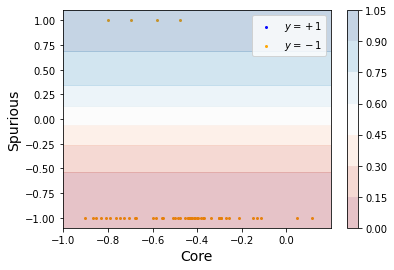

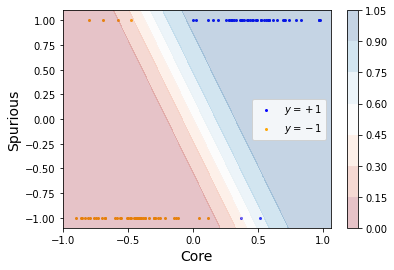

ep: 16000 ml: 0.029 al: -1.269 train: 1.00 test_id: 0.96 test_ood: 0.82 gamma: 0.142821


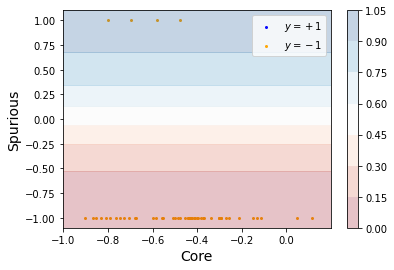

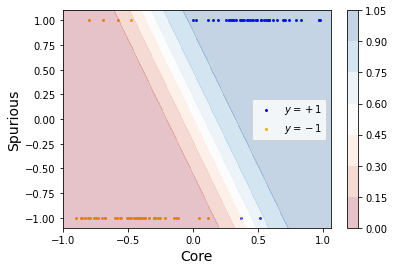

ep: 18000 ml: 0.032 al: -1.187 train: 1.00 test_id: 0.96 test_ood: 0.82 gamma: 0.153522


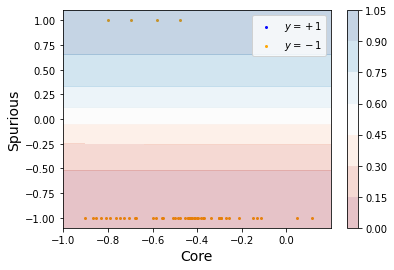

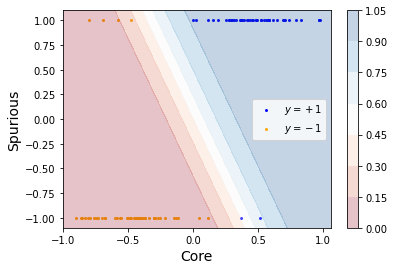

In [24]:
set_seed(SEED)

m = Model(dim=dim, C=2).cuda()
a = Adv(dim=dim, t=1).cuda()
lr_m = 0.01
lr_a = 0.01
loss_m = torch.nn.CrossEntropyLoss(reduction='none')
loss_a = torch.nn.MSELoss(reduction='none')
opt_m = torch.optim.SGD(m.parameters(), lr=lr_m, weight_decay=0.01)
opt_a = torch.optim.SGD(a.parameters(), lr = lr_a)
n_epochs = 20000

def get_acc(x, y, m):
    xte = x.cuda()
    yte = ((y+1) / 2).long().cuda()
    with torch.no_grad():
            return ((torch.nn.functional.softmax(m(xte), dim=1)[:, 1] >=0.5).long() == yte).sum() / len(yte)

xt = x_tr.cuda()
yt = ((y_tr+1) / 2).long().cuda()

# initialize weights to uniform
gamma = 0.002
B = 64

for ep in range(n_epochs):
    # sample batch
    idx = np.random.choice(len(yt), B)
    bxt, byt = xt[idx], yt[idx]
    # compute loss
    ml = loss_m(m(bxt), byt)
    # compute wts
    wts = torch.sigmoid(a.get_scaled_logits(bxt, byt).squeeze())
    # wts = a(bxt, byt).squeeze()
    # update learner
    opt_m.zero_grad()
    (((ml * wts).sum())).backward()  
    opt_m.step()
    # update weights
    
    for _ in range(1):
        al = 0.
        with torch.no_grad():
            ml = loss_m(m(bxt), byt)
        gamma = torch.quantile(ml, 0.95).item()
            
        def closure():
            global al
            al = 0.
            wts = torch.sigmoid(a.get_scaled_logits(bxt, byt).squeeze())
            # wts = a(bxt, byt).squeeze()
            for y in range(2):
                y_adv = ml[byt==y].float()
                # y_adv = ml[byt==y]
                al += (wts[byt==y] * (y_adv - gamma)).sum() - 0.1 * torch.norm(a.classifier[y].weight, p=1)
            opt_a.zero_grad()
            (-al).backward()  
            return al
        opt_a.step(closure) 
    
    if ep % 2000 == 0:
        train_acc = get_acc(x_tr, y_tr, m)
        test_id_acc = get_acc(x_te_id, y_te_id, m)
        test_ood_acc = get_acc(x_te_ood, y_te_ood, m)
        print('ep: {:d} ml: {:.3f} al: {:.3f} train: {:.2f} test_id: {:.2f} test_ood: {:.2f} gamma: {:2f}'.format(ep, ml.mean().item(), al.mean().item(), train_acc, test_id_acc, test_ood_acc, gamma))
        plot_dbdry(x_tr[y_tr==-1, :], y_tr[y_tr==-1], Dummy(a.classifier[0], a.t), noise_dim=10)
        plt.show()
        plot_dbdry(x_tr, y_tr, m, noise_dim=10)
        plt.show()

In [14]:
from torch.optim import Optimizer
import math

class OptMirrorAdam(Optimizer):
    """Implements Optimistic Adam algorithm. Built on official implementation of Adam by pytorch. 
       See "Optimistic Mirror Descent in Saddle-Point Problems: Gointh the Extra (-Gradient) Mile"
       double blind review, paper: https://openreview.net/pdf?id=Bkg8jjC9KQ 

    Standard Adam 
    It has been proposed in `Adam: A Method for Stochastic Optimization`_.

    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsgrad (boolean, optional): whether to use the AMSGrad variant of this
            algorithm from the paper `On the Convergence of Adam and Beyond`_

    .. _Adam\: A Method for Stochastic Optimization:
        https://arxiv.org/abs/1412.6980
    .. _On the Convergence of Adam and Beyond:
        https://openreview.net/forum?id=ryQu7f-RZ
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=0, amsgrad=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, amsgrad=amsgrad)
        super(OptMirrorAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(OptMirrorAdam, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)

    def step(self, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        
        loss = None
        
        # Do not allow training with out closure 
        if closure is  None:
            raise ValueError("This algorithm requires a closure definition for the evaluation of the intermediate gradient")
            
        
        # Create a copy of the initial parameters 
        param_groups_copy = self.param_groups.copy()
        
        # ############### First update of gradients ############################################
        # ######################################################################################
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')
                amsgrad = group['amsgrad']

                state = self.state[p]
                # @@@@@@@@@@@@@@@ State initialization @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg_1'] = torch.zeros_like(p.data)
                    state['exp_avg_2'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq_1'] = torch.zeros_like(p.data)
                    state['exp_avg_sq_2'] = torch.zeros_like(p.data)
                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq_1'] = torch.zeros_like(p.data)
                        state['max_exp_avg_sq_2'] = torch.zeros_like(p.data)
                # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 
                        
                        
                        
                        
                exp_avg1, exp_avg_sq1 = state['exp_avg_1'], state['exp_avg_sq_1']
                if amsgrad:
                    max_exp_avg_sq1 = state['max_exp_avg_sq_1']
                beta1, beta2 = group['betas']

                
                # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 
                # Step will be updated once  
                state['step'] += 1
                # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
                
                
                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg1.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq1.mul_(beta2).addcmul_(1 - beta2, grad, grad)

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']

                # *****************************************************
                # Additional steps, to get bias corrected running means  
                exp_avg1 = torch.div(exp_avg1, bias_correction1)
                exp_avg_sq1 = torch.div(exp_avg_sq1, bias_correction2)
                # *****************************************************
                                
                if amsgrad:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq1, exp_avg_sq1, out=max_exp_avg_sq1)
                    # Use the max. for normalizing running avg. of gradient
                    denom1 = max_exp_avg_sq1.sqrt().add_(group['eps'])
                else:
                    denom1 = exp_avg_sq1.sqrt().add_(group['eps'])

                step_size1 = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                p.data.addcdiv_(-step_size1, exp_avg1, denom1)


        
        # Perform additional backward step to calculate stochastic gradient - WATING STATE 
        loss = closure()
        

        # ############### Second evaluation of gradient step #######################################
        # ######################################################################################
        for (group, group_copy) in zip(self.param_groups,param_groups_copy ):
            for (p, p_copy) in zip(group['params'],group_copy['params']):
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')
                amsgrad = group['amsgrad']

                state = self.state[p]

                        
                        
                exp_avg2, exp_avg_sq2 = state['exp_avg_2'], state['exp_avg_sq_2']
                if amsgrad:
                    max_exp_avg_sq2 = state['max_exp_avg_sq_2']
                beta1, beta2 = group['betas']
                
                
                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg2.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq2.mul_(beta2).addcmul_(1 - beta2, grad, grad)

                # *****************************************************
                # Additional steps, to get bias corrected running means  
                exp_avg2 = torch.div(exp_avg2, bias_correction1)
                exp_avg_sq2 = torch.div(exp_avg_sq2, bias_correction2)
                # *****************************************************
                                
                if amsgrad:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq2, exp_avg_sq2, out=max_exp_avg_sq2)
                    # Use the max. for normalizing running avg. of gradient
                    denom2 = max_exp_avg_sq2.sqrt().add_(group['eps'])
                else:
                    denom2 = exp_avg_sq2.sqrt().add_(group['eps'])

                step_size2 = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                p_copy.data.addcdiv_(-step_size2, exp_avg2, denom2)
                p = p_copy # pass parameters to the initial weight variables.
        
        
        
        
        return loss

ep: 0 ml: 1.300 al: -1.135 train: 0.44 test_id: 0.39 test_ood: 0.50 gamma: 0.083552


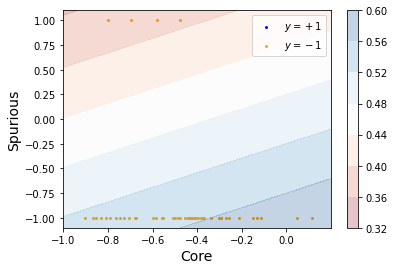

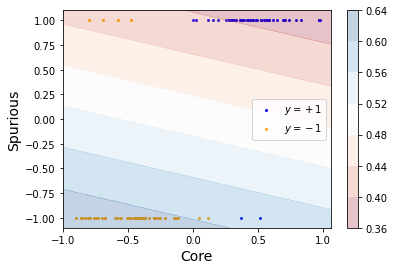

ep: 2000 ml: 0.020 al: -1.135 train: 1.00 test_id: 0.96 test_ood: 0.79 gamma: 0.083552


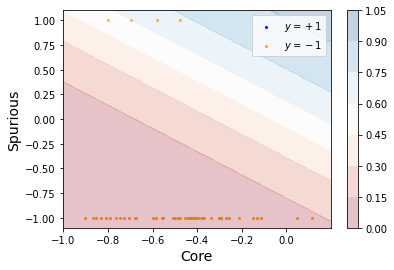

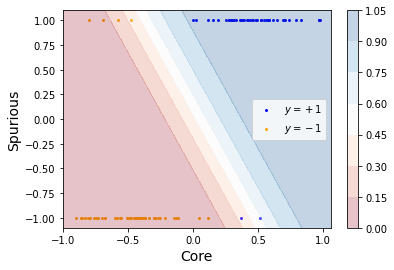

ep: 4000 ml: 0.008 al: -1.135 train: 1.00 test_id: 0.97 test_ood: 0.79 gamma: 0.083552


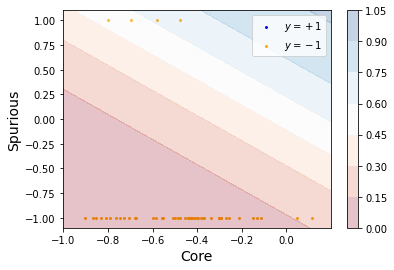

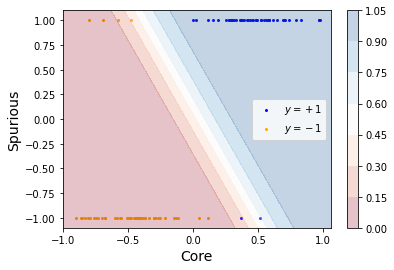

ep: 6000 ml: 0.013 al: -1.135 train: 1.00 test_id: 0.96 test_ood: 0.79 gamma: 0.083552


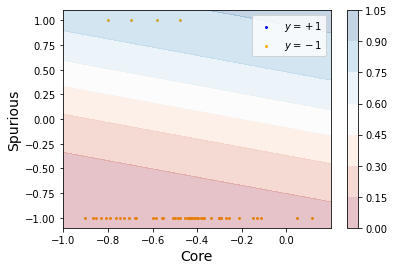

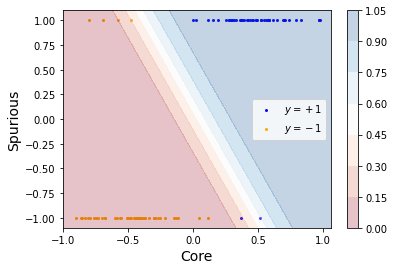

ep: 8000 ml: 0.043 al: -1.135 train: 0.98 test_id: 0.95 test_ood: 0.83 gamma: 0.083552


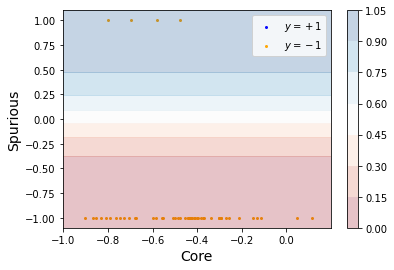

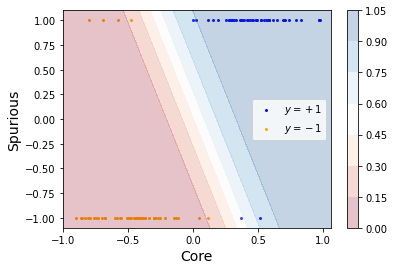

ep: 10000 ml: 0.048 al: -1.135 train: 0.98 test_id: 0.94 test_ood: 0.85 gamma: 0.083552


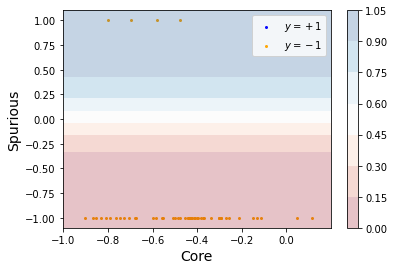

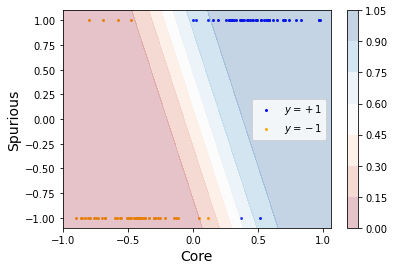

ep: 12000 ml: 0.086 al: -1.135 train: 0.98 test_id: 0.93 test_ood: 0.84 gamma: 0.083552


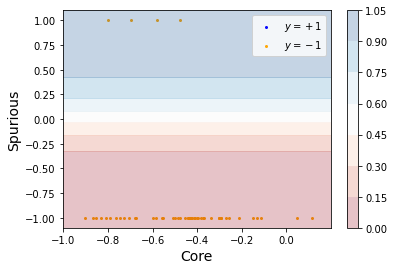

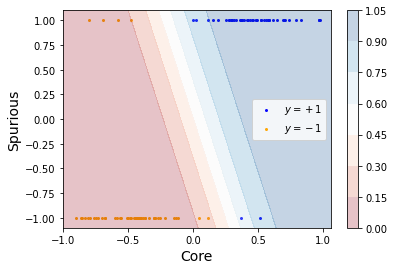

ep: 14000 ml: 0.104 al: -1.135 train: 0.97 test_id: 0.93 test_ood: 0.84 gamma: 0.083552


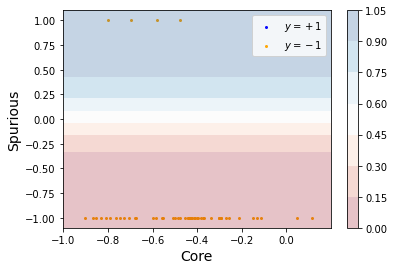

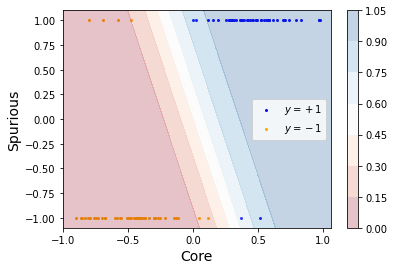

ep: 16000 ml: 0.067 al: -1.135 train: 0.98 test_id: 0.94 test_ood: 0.84 gamma: 0.083552


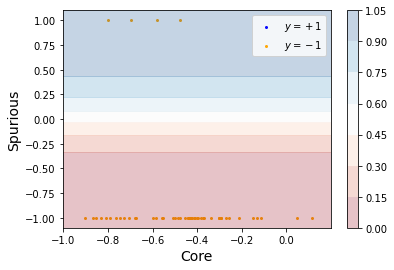

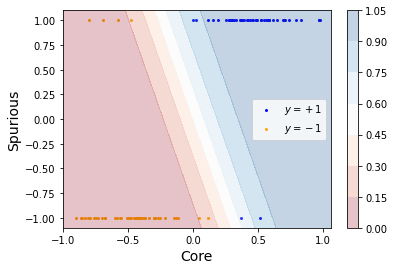

ep: 18000 ml: 0.086 al: -1.135 train: 0.98 test_id: 0.94 test_ood: 0.84 gamma: 0.083552


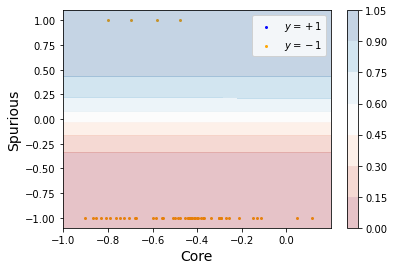

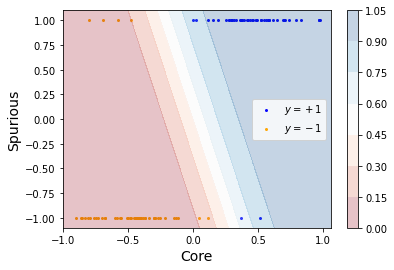

In [25]:
set_seed(SEED)

m = Model(dim=dim, C=2).cuda()
a = Adv(dim=dim, t=1).cuda()
lr_m = 0.01
lr_a = 0.01
loss_m = torch.nn.CrossEntropyLoss(reduction='none')
loss_a = torch.nn.MSELoss(reduction='none')
opt_m = OptMirrorAdam(m.parameters(), lr=lr_m, weight_decay=0.01)
opt_a = torch.optim.Adam(a.parameters(), lr = lr_a)
n_epochs = 20000

def get_acc(x, y, m):
    xte = x.cuda()
    yte = ((y+1) / 2).long().cuda()
    with torch.no_grad():
            return ((torch.nn.functional.softmax(m(xte), dim=1)[:, 1] >=0.5).long() == yte).sum() / len(yte)

xt = x_tr.cuda()
yt = ((y_tr+1) / 2).long().cuda()

B = 128

for ep in range(n_epochs):
    # sample batch
    idx = np.random.choice(len(yt), B)
    bxt, byt = xt[idx], yt[idx]
    
    ml = loss_m(m(bxt), byt) # compute loss
    with torch.no_grad():
        wts = torch.sigmoid(a.get_scaled_logits(bxt, byt).squeeze()) # compute wts
    opt_m.zero_grad() 
    ((ml * wts).sum()).backward() # multiply loss and wts
    
    def closure_m():
        with torch.no_grad():
            ml = loss_m(m(bxt), byt) # compute loss
        gamma = torch.quantile(ml, 0.95).item()
        al = 0.
        wts = torch.sigmoid(a.get_scaled_logits(bxt, byt).squeeze())
        for y in range(2):
            y_adv = ml[byt==y].float()
            al += (wts[byt==y] * (y_adv - gamma)).sum() - 0.1 * torch.norm(a.classifier[y].weight, p=1)
        opt_a.zero_grad()
        (-al).backward()
        opt_a.step()

        ml = loss_m(m(bxt), byt) # compute loss
        with torch.no_grad():
            wts = torch.sigmoid(a.get_scaled_logits(bxt, byt).squeeze()) # compute wts
        opt_m.zero_grad() 
        ((ml * wts).sum()).backward() # multiply loss and wts

    opt_m.step(closure_m)    
            
        
    if ep % 2000 == 0:
        train_acc = get_acc(x_tr, y_tr, m)
        test_id_acc = get_acc(x_te_id, y_te_id, m)
        test_ood_acc = get_acc(x_te_ood, y_te_ood, m)
        print('ep: {:d} ml: {:.3f} al: {:.3f} train: {:.2f} test_id: {:.2f} test_ood: {:.2f} gamma: {:2f}'.format(ep, ml.mean().item(), al.mean().item(), train_acc, test_id_acc, test_ood_acc, gamma))
        plot_dbdry(x_tr[y_tr==-1, :], y_tr[y_tr==-1], Dummy(a.classifier[0], a.t), noise_dim=10)
        plt.show()
        plot_dbdry(x_tr, y_tr, m, noise_dim=10)
        plt.show()

In [52]:
wts

tensor([0.2093, 0.2991, 0.2814, 0.3660, 0.1676, 0.2801, 0.1593, 0.7684, 0.4125,
        0.2749, 0.2577, 0.2955, 0.3100, 0.1830, 0.7128, 0.2121, 0.2053, 0.4274,
        0.3544, 0.2896, 0.3369, 0.2985, 0.1931, 0.2907, 0.3081, 0.2645, 0.3250,
        0.2044, 0.3186, 0.2851, 0.2097, 0.3661, 0.2709, 0.2272, 0.3605, 0.2041,
        0.2843, 0.1657, 0.3119, 0.1803, 0.2386, 0.1624, 0.3233, 0.2741, 0.1742,
        0.2753, 0.2435, 0.4337, 0.2047, 0.2648, 0.2365, 0.3500, 0.1822, 0.1786,
        0.1207, 0.6242, 0.2074, 0.2244, 0.2720, 0.3002, 0.6625, 0.7709, 0.2069,
        0.1899, 0.3711, 0.2235, 0.2324, 0.1490, 0.3030, 0.2662, 0.1768, 0.3008,
        0.2505, 0.1371, 0.2608, 0.1431, 0.2279, 0.2564, 0.2139, 0.2472, 0.1929,
        0.2370, 0.7196, 0.1595, 0.2411, 0.1823, 0.1811, 0.2799, 0.2936, 0.3351,
        0.3788, 0.2337, 0.2370, 0.1984, 0.2465, 0.2472, 0.2376, 0.2311, 0.2648,
        0.2507], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [ ]:
v = torch.ones(len(yt))

set_seed(SEED)

K = 256
dim = 12
m = Model(dim=dim, K=K, C=2).cuda()

lr = 1e-3
lossfn = torch.nn.CrossEntropyLoss(reduction='none')
opt = torch.optim.SGD(m.parameters(), lr=lr)
n_epochs = 10000

def get_acc(x, y, m):
    xte = x.cuda()
    yte = ((y+1) / 2).long().cuda()
    with torch.no_grad():
        return ((torch.nn.functional.softmax(m(xte), dim=1)[:, 1] >=0.5).long() == yte).sum() / len(yte)

xt = x_tr.cuda()
yt = ((y_tr+1) / 2).long().cuda()

for ep in range(n_epochs):
    opt.zero_grad()
    logits = m(xt)
    loss = lossfn(logits, yt)
    (max(loss[[xt[:, 1] * (yt-0.5) < 0]].mean(), loss[[xt[:, 1] * (yt-0.5) > 0]].mean())).backward()
    opt.step()
        
    if ep % 500 == 0:
        train_acc = get_acc(x_tr, y_tr, m)
        test_id_acc = get_acc(x_te_id, y_te_id, m)
        test_ood_acc = get_acc(x_te_ood, y_te_ood, m)
        print('ep: {:d} loss: {:.3f} train: {:.2f} test_id: {:.2f} test_ood: {:.2f}'.format(ep, loss.mean().item(), train_acc, test_id_acc, test_ood_acc))

In [159]:
# JTT
set_seed(SEED)
m = Model(dim=dim, C=2).cuda()

lr = 0.001
lossfn = torch.nn.CrossEntropyLoss(reduction='none')
opt = torch.optim.SGD(m.parameters(), lr=lr)
n_epochs = 20000

def get_acc(x, y, m):
    xte = x.cuda()
    yte = ((y+1) / 2).long().cuda()
    with torch.no_grad():
        return ((torch.nn.functional.softmax(m(xte), dim=1)[:, 1] >=0.5).long() == yte).sum() / len(yte)

xt = x_tr.cuda()
yt = ((y_tr+1) / 2).long().cuda()

gid = torch.ones(len(xt)).cuda()

for ep in range(n_epochs):
    opt.zero_grad()
    logits = m(xt)
    loss_vec = lossfn(logits, yt)
    loss = (loss_vec @ gid / (gid.sum()))
    loss.backward()
    opt.step() 
    
    if ep == 5000:
        print("Computing group weights ...")
        gid = loss_vec.detach()
            
    if ep % 500 == 0:
        train_acc = get_acc(x_tr, y_tr, m)
        test_id_acc = get_acc(x_te_id, y_te_id, m)
        test_ood_acc = get_acc(x_te_ood, y_te_ood, m)
        # print("ep: ", ep, "adv_it: ", adv_it)
        # plot_dbdry(x_tr, y_tr, m)
        # plt.show()
        # plot_dbdry(x_tr, y_tr, adv)
        # plt.show()

        print('loss: {:.3f} train: {:.2f} test_id: {:.2f} test_ood: {:.2f}'.format(loss.item(), train_acc, test_id_acc, test_ood_acc))

loss: 1.251 train: 0.42 test_id: 0.39 test_ood: 0.50
loss: 0.867 train: 0.57 test_id: 0.53 test_ood: 0.54
loss: 0.607 train: 0.62 test_id: 0.67 test_ood: 0.57
loss: 0.444 train: 0.81 test_id: 0.80 test_ood: 0.58
loss: 0.345 train: 0.89 test_id: 0.88 test_ood: 0.57
loss: 0.284 train: 0.91 test_id: 0.93 test_ood: 0.57
loss: 0.244 train: 0.94 test_id: 0.95 test_ood: 0.55
loss: 0.217 train: 0.95 test_id: 0.95 test_ood: 0.54
loss: 0.198 train: 0.96 test_id: 0.96 test_ood: 0.53
loss: 0.183 train: 0.95 test_id: 0.96 test_ood: 0.52
Computing group weights ...
loss: 0.171 train: 0.95 test_id: 0.95 test_ood: 0.51
loss: 0.381 train: 0.98 test_id: 0.96 test_ood: 0.54
loss: 0.329 train: 0.98 test_id: 0.96 test_ood: 0.57
loss: 0.297 train: 0.99 test_id: 0.96 test_ood: 0.59
loss: 0.274 train: 0.99 test_id: 0.96 test_ood: 0.61
loss: 0.256 train: 0.99 test_id: 0.96 test_ood: 0.63
loss: 0.242 train: 0.99 test_id: 0.95 test_ood: 0.64
loss: 0.230 train: 0.99 test_id: 0.95 test_ood: 0.64
loss: 0.219 train:

In [ ]:
plot_dbdry(x_tr, y_tr, m)

In [ ]:
from numbers import Number
import torch.nn.functional as F
import torch.nn.init as init
from torch.autograd import Variable
import torch.nn as nn

In [ ]:
# model
class VIBAdv(torch.nn.Module):
    
    def __init__(self, dim, z_dim):
        super(VIBAdv, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(dim, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, z_dim * 2),
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(z_dim, 2),
        )        
        self.z_dim = z_dim
        self.init()
        
    def init(self):
        for m in self.modules():
            if isinstance(m, torch.nn.Linear):
                torch.nn.init.kaiming_normal_(m.weight)
                torch.nn.init.zeros_(m.bias)
                
    def reparametrize_n(self, mu, std, n=100):
        # reference :
        # http://pytorch.org/docs/0.3.1/_modules/torch/distributions.html#Distribution.sample_n
        def expand(v):
            if isinstance(v, Number):
                return torch.Tensor([v]).expand(n, 1)
            else:
                return v.expand(n, *v.size())

        if n != 1 :
            mu = expand(mu)
            std = expand(std)

        eps = Variable(std.data.new(std.size()).normal_().cuda())

        return mu + eps * std
    
    def sample(self, mu, sigma):
        return mu + torch.randn(mu.size()).cuda() * sigma
        
    def forward(self, x):
        mu = self.encoder(x)[:, :self.z_dim]
        sigma = std = F.softplus(self.encoder(x)[:, self.z_dim:]-5,beta=1)
        logits = self.decoder(self.reparametrize_n(mu, sigma))
        probs = F.softmax(logits, dim=2).mean(0)
        return probs[:, 1], (mu, sigma)

In [ ]:
set_seed(SEED)
dim = 12
K = 256
m = Model(dim=dim, K=K, C=2).cuda()
adv = VIBAdv(dim=dim, z_dim=16).cuda()

lr = 1e-3
adv_lr = 5e-3
lossfn = torch.nn.CrossEntropyLoss(reduction='none')
opt = torch.optim.SGD(m.parameters(), lr=lr, weight_decay=0.)
opt_adv = torch.optim.SGD(adv.parameters(), lr=adv_lr, weight_decay=0.05)
n_epochs = 10000

def get_acc(x, y, m):
    xte = x.cuda()
    yte = ((y+1) / 2).long().cuda()
    with torch.no_grad():
        return ((torch.nn.functional.softmax(m(xte), dim=1)[:, 1] >=0.5).long() == yte).sum() / len(yte)

xt = x_tr.cuda()
yt = ((y_tr+1) / 2).long().cuda()
gid = torch.ones(len(yt)).cuda()

for ep in range(n_epochs):
    opt.zero_grad()
    logits = m(xt)
    loss_vec = lossfn(logits, yt)
    
    if ep % 1 == 0:
        P = torch.pow(loss_vec, 10).detach()
        for _ in range(1):
            gid, (mu, std) = adv(xt)
            info_loss = -0.5*(1+2*std.log()-mu.pow(2)-std.pow(2)).sum(1).mean()    
            loss = - (loss_vec.detach() @ gid / (gid.sum() + 1e-5))
            # print(loss, info_loss, gid.shape, loss_vec.shape)
            opt_adv.zero_grad()
            a_grads = torch.autograd.grad(loss + 0.01 * info_loss, adv.parameters())
            for p, p_grad in zip(adv.parameters(), a_grads):
                p.grad = p_grad
            opt_adv.step()

    logits = m(xt)
    loss_vec = lossfn(logits, yt)
    loss = (loss_vec @ gid / (gid.sum() + 1e-5))
    
    opt.zero_grad()
    m_grads = torch.autograd.grad(loss, m.parameters(), retain_graph=True)
    for p, p_grad in zip(m.parameters(), m_grads):
        p.grad = p_grad
    opt.step()
    

    
    if ep % 1000 == 0:
        train_acc = get_acc(x_tr, y_tr, m)
        test_id_acc = get_acc(x_te_id, y_te_id, m)
        test_ood_acc = get_acc(x_te_ood, y_te_ood, m)
        plot_dbdry(x_tr, y_tr, m)
        plt.scatter([adv_mean.detach().cpu().numpy()[0]], [adv_mean.detach().cpu().numpy()[1]])
        plt.show()
        print('loss: {:.3f} min_wts: {:.3f} maj_wts: {:.3f} train: {:.2f} test_id: {:.2f} test_ood: {:.2f}'.format(loss.item(), gid[xt[:, 1] * (yt-0.5) < 0].mean(), gid[xt[:, 1] * (yt-0.5) > 0].mean(), train_acc, test_id_acc, test_ood_acc))